In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat

import torch
import torch.nn as nn
from neuralop.models import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
n_batch = 16
n_timesteps = 33
nx, ny, nz = 100, 100, 11

In [3]:
tsteps = np.concatenate([np.logspace(-3,0,num=10),
                         np.linspace(1.5, 10, num=18),
                         np.arange(30, 120, step=20)])
timesteps = np.expand_dims(np.moveaxis(np.tile(np.expand_dims(tsteps, -1), 16), -1, 0), -1)
print(tsteps)

[1.00000000e-03 2.15443469e-03 4.64158883e-03 1.00000000e-02
 2.15443469e-02 4.64158883e-02 1.00000000e-01 2.15443469e-01
 4.64158883e-01 1.00000000e+00 1.50000000e+00 2.00000000e+00
 2.50000000e+00 3.00000000e+00 3.50000000e+00 4.00000000e+00
 4.50000000e+00 5.00000000e+00 5.50000000e+00 6.00000000e+00
 6.50000000e+00 7.00000000e+00 7.50000000e+00 8.00000000e+00
 8.50000000e+00 9.00000000e+00 9.50000000e+00 1.00000000e+01
 3.00000000e+01 5.00000000e+01 7.00000000e+01 9.00000000e+01
 1.10000000e+02]


In [4]:
mask = loadmat('data_100_100_11/G_cells_indexMap.mat')['gci']

Grid = np.zeros((nx, ny, nz)).flatten(order='F')
Grid[mask] = 1
Grid = Grid.reshape(nx, ny, nz, order='F')

Grid_ext = np.moveaxis(np.tile(np.expand_dims(Grid, -1), 3), -1, 0)
Grid_ext = np.moveaxis(np.tile(np.expand_dims(Grid_ext, -1), n_batch), -1, 0)

print('mask: {} | Grid: {} | Grid_ext: {}'.format(mask.shape, Grid.shape, Grid_ext.shape))

mask: (29128, 1) | Grid: (100, 100, 11) | Grid_ext: (16, 3, 100, 100, 11)


Grid_ext_flat: (16, 3, 110000)
m: (16, 3, 100, 100, 11) | m_flat: (16, 3, 110000) | m_masked: (16, 3, 100, 100, 11) | m_ensemble: (16, 3, 100, 100, 5)


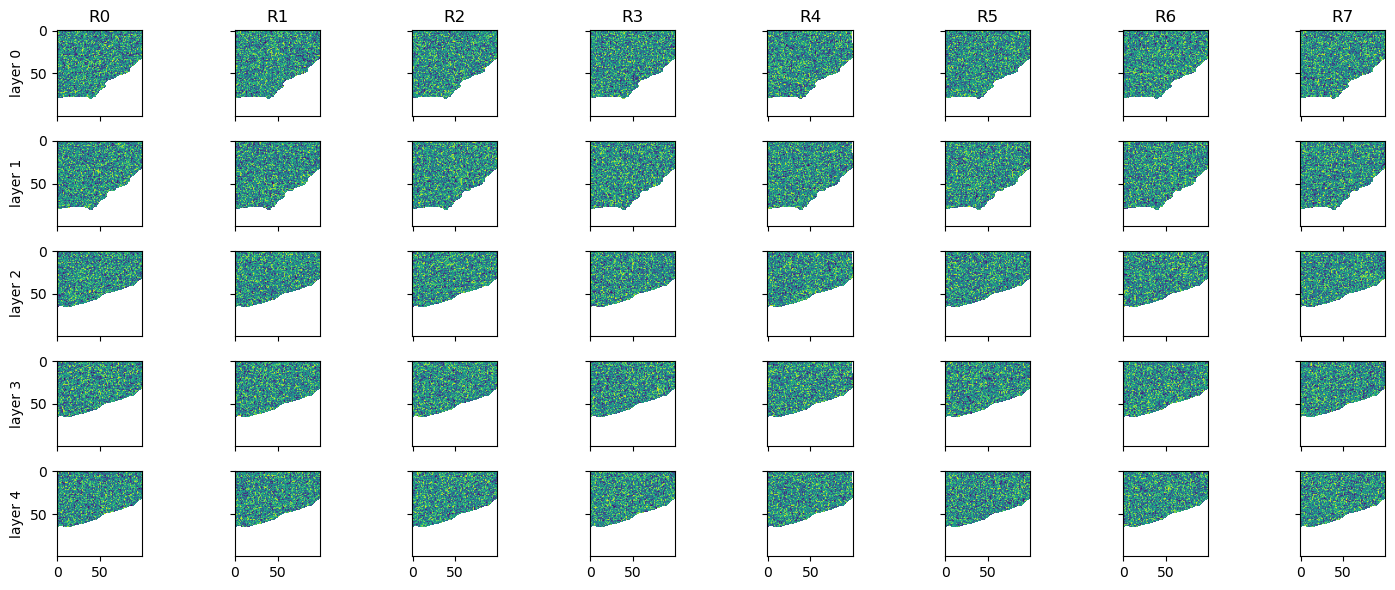

In [5]:
m = np.random.uniform(size=(n_batch, 3, nx, ny, nz))
m_flat = m.reshape(n_batch, 3, -1, order='F')

Grid_ext_flat = Grid_ext.reshape(n_batch, 3, -1, order='F')

m_masked_flat = np.ma.masked_where(Grid_ext_flat==0, m_flat)
m_masked = m_masked_flat.reshape(n_batch, 3, nx, ny, nz, order='F')

m_ensemble = m_masked[...,5:10]

print('Grid_ext_flat: {}'.format(Grid_ext_flat.shape))
print('m: {} | m_flat: {} | m_masked: {} | m_ensemble: {}'.format(m.shape, m_flat.shape, m_masked.shape, m_ensemble.shape))

fig, axs = plt.subplots(5, 8, figsize=(15,6), sharex=True, sharey=True)
for i in range(5):
    for j in range(8):
        ax = axs[i,j]
        ax.imshow(m_ensemble[j,0,:,:,i])
        ax.set_title('R{}'.format(j)) if i==0 else None
    axs[i,0].set_ylabel('layer {}'.format(i))
plt.tight_layout()
plt.show()

Well Controls: (16, 33, 5)


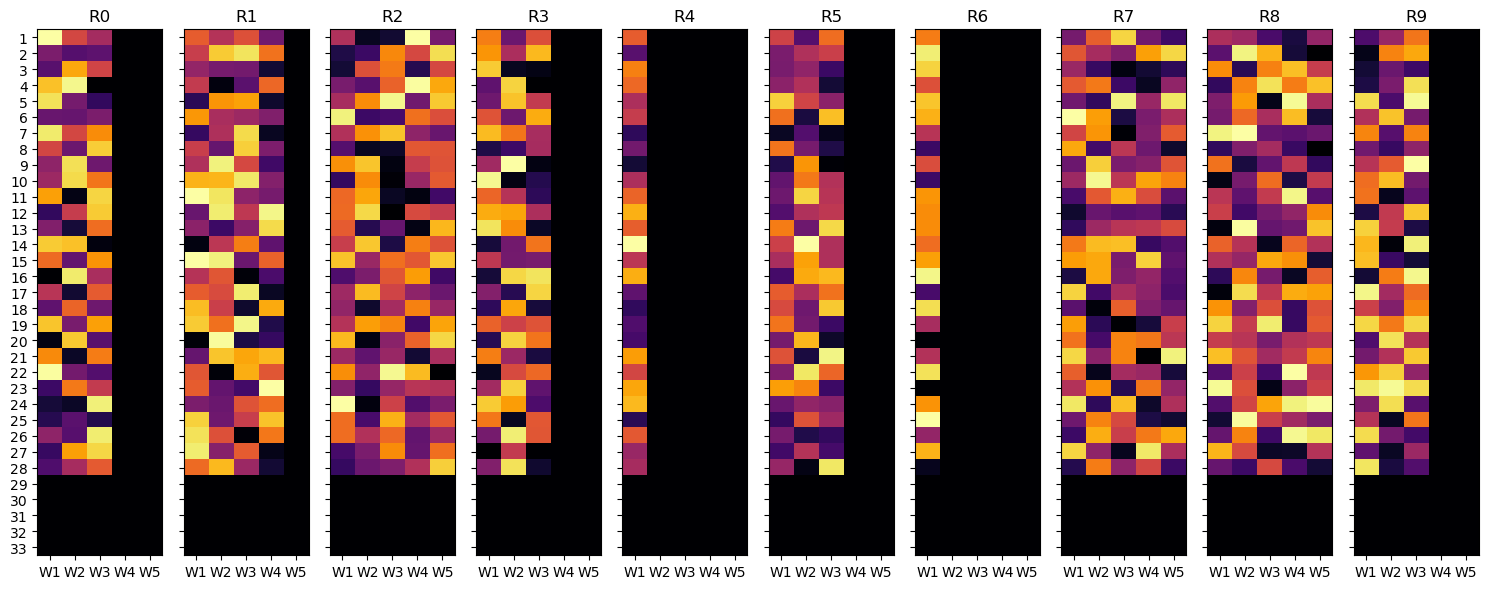

In [6]:
well_ctrl = np.zeros((n_batch, n_timesteps, 5))
n_wells = []
for b in range(n_batch):
    nw = np.random.randint(1,6)
    n_wells.append(nw)
    for w in range(nw):
        c = np.concatenate([np.random.uniform(size=(1,28)), np.zeros((1,5))], axis=-1).squeeze()
        well_ctrl[b,:,w] = c

print('Well Controls: {}'.format(well_ctrl.shape))

fig, axs = plt.subplots(1, 10, figsize=(15,6), sharex=True, sharey=True)
for j in range(10):
    ax = axs[j]
    ax.imshow(well_ctrl[j], aspect='auto', cmap='inferno')
    ax.set_title('R{}'.format(j))
    ax.set(yticks=np.arange(33), xticks=np.arange(5), yticklabels=np.arange(1,34), xticklabels=['W{}'.format(i) for i in range(1,6)])
plt.tight_layout()
plt.show()

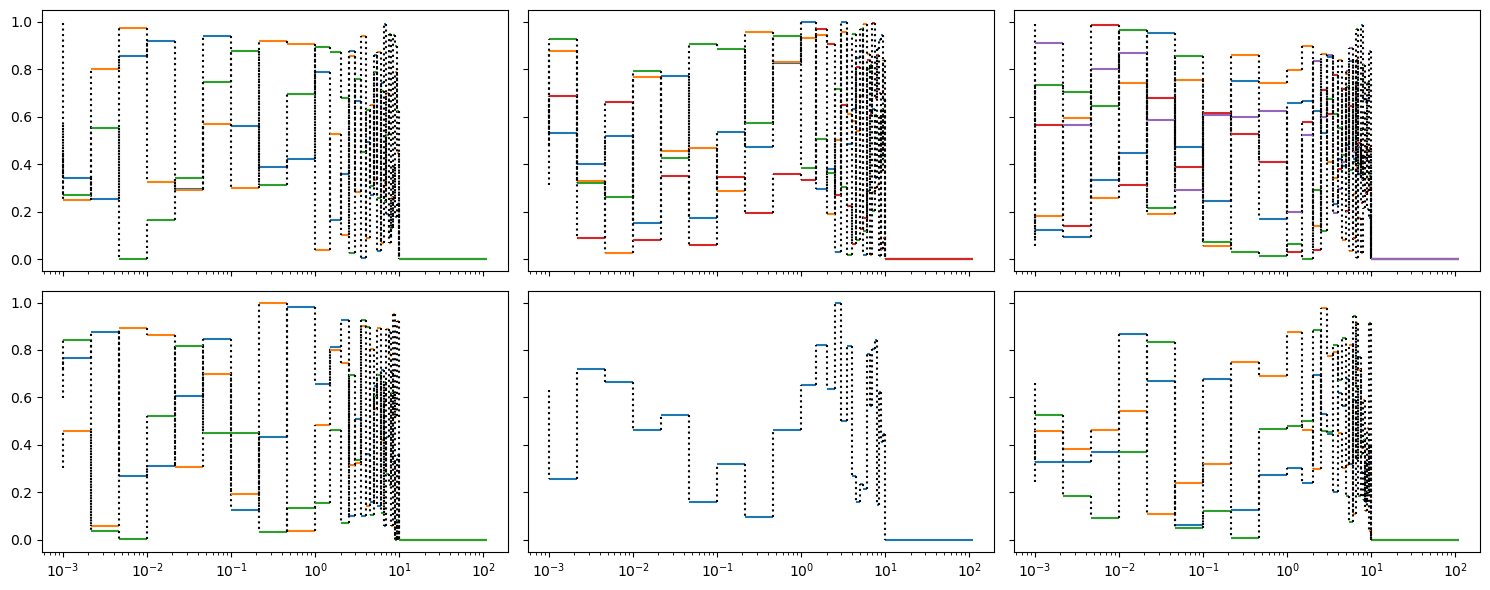

In [46]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)
k = 0
for i in range(2):
    for j in range(3):
        ax = axs[i,j]
        for w in range(n_wells[k]):
            for t in range(1,n_timesteps):
                lh = ax.hlines(well_ctrl[k,t,w], timesteps[k,t-1,:], timesteps[k,t,:], color=colors[w])
                lv = ax.vlines(timesteps[k,t-1,:], well_ctrl[k,t-1,w], well_ctrl[k,t,w], ls=':', color='k')
        k += 1
        ax.set(xscale='log')
plt.tight_layout()
plt.show()

Well Locations: (16, 2, 5)


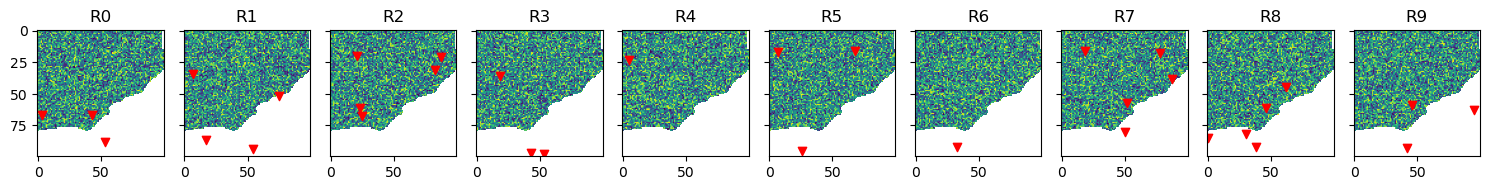

In [7]:
well_locs = np.zeros((n_batch, 2, 5), dtype='int')
for b in range(n_batch):
    nw = n_wells[b]
    idx = np.random.randint(0, 100, nw)
    idy = np.random.randint(0, 100, nw)
    locs = np.array([idx, idy])
    for w in range(nw):
        well_locs[b,:,w] = locs[:,w]

print('Well Locations: {}'.format(well_locs.shape))

fig, axs = plt.subplots(1, 10, figsize=(15,6), sharex=True, sharey=True)
for j in range(10):
    ax = axs[j]
    ax.imshow(m_ensemble[j,0,:,:,0])
    for w in range(n_wells[j]):
        ax.scatter(well_locs[j,1,w], well_locs[j,0,w], c='r', marker='v')
    ax.set(title='R{}'.format(j))
plt.tight_layout()
plt.show()

In [8]:
xm = torch.tensor(m_ensemble, dtype=torch.float32).to(device)
xc = torch.tensor(well_ctrl, dtype=torch.float32).to(device)
xw = torch.tensor(well_locs, dtype=torch.float32).permute(0,2,1).to(device)
xt = torch.tensor(timesteps, dtype=torch.float32).to(device)
print('xm: {}\nxc: {}\nxw: {}\nxt: {}'.format(xm.shape, xc.shape, xw.shape, xt.shape))

xm: torch.Size([16, 3, 100, 100, 5])
xc: torch.Size([16, 33, 5])
xw: torch.Size([16, 5, 2])
xt: torch.Size([16, 33, 1])


In [9]:
class FMiONet(nn.Module):
    def __init__(self, n_channels:int=100):
        super(FMiONet, self).__init__()
        self.n_ch = n_channels
        self.line1 = nn.Linear(5, self.n_ch)
        self.line2 = nn.Linear(2, self.n_ch)
        self.line3 = nn.Linear(1, self.n_ch)
        self.lift  = nn.Linear(270, 331)
        self.conv1 = nn.Conv3d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(16, self.n_ch, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.pool2 = nn.MaxPool3d((2,2,1))
        self.fno   = FNO1d(n_modes_height=4, n_layers=4, 
                           fno_block_precision='half', stabilizer='tanh', norm='instance_norm', 
                           in_channels=33, lifting_channels=64, hidden_channels=128, projection_channels=64, out_channels=33)
        
    def forward(self, x):
        xm, xc, xw, xt = x
        zc = self.line1(xc)
        zw = self.line2(xw)
        zt = self.line3(xt)

        zm = self.pool1(self.conv1(xm))
        zm = self.pool1(self.conv2(zm))
        zm = self.pool2(self.conv3(zm))
        zm = zm.view(zm.shape[0], zm.shape[1], -1)
        
        b12 = torch.einsum('btc, bwc -> btwc', zc, zw).reshape(n_batch, -1, self.n_ch)
        b123 = torch.einsum('bkc, bcp -> bkpc', b12, zm).reshape(n_batch, -1, self.n_ch)
        btm = torch.einsum('btc, bkc -> btk', zt, b123).reshape(n_batch, n_timesteps, 88, 270)
        
        zo = self.lift(btm).reshape(n_batch, n_timesteps, -1)
        z = self.fno(zo)
        return z
    
model = FMiONet().to(device)
print('# params: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# params: 618,390


In [22]:
y_pred = model((xm, xc, xw, xt))
print('y_pred: {}'.format(y_pred.shape))

y_pred: torch.Size([16, 33, 29128])


In [23]:
y_grid = np.zeros((n_batch, n_timesteps, nx, ny, nz)).reshape(n_batch, n_timesteps, -1, order='F')
y_grid[:,:,mask.squeeze()] =  y_pred.detach().cpu().numpy().reshape(n_batch, n_timesteps, -1, order='F')
y_pred = y_grid.reshape(n_batch, n_timesteps, nx, ny, nz, order='F')[...,5:10]

print(y_pred.shape)

(16, 33, 100, 100, 5)


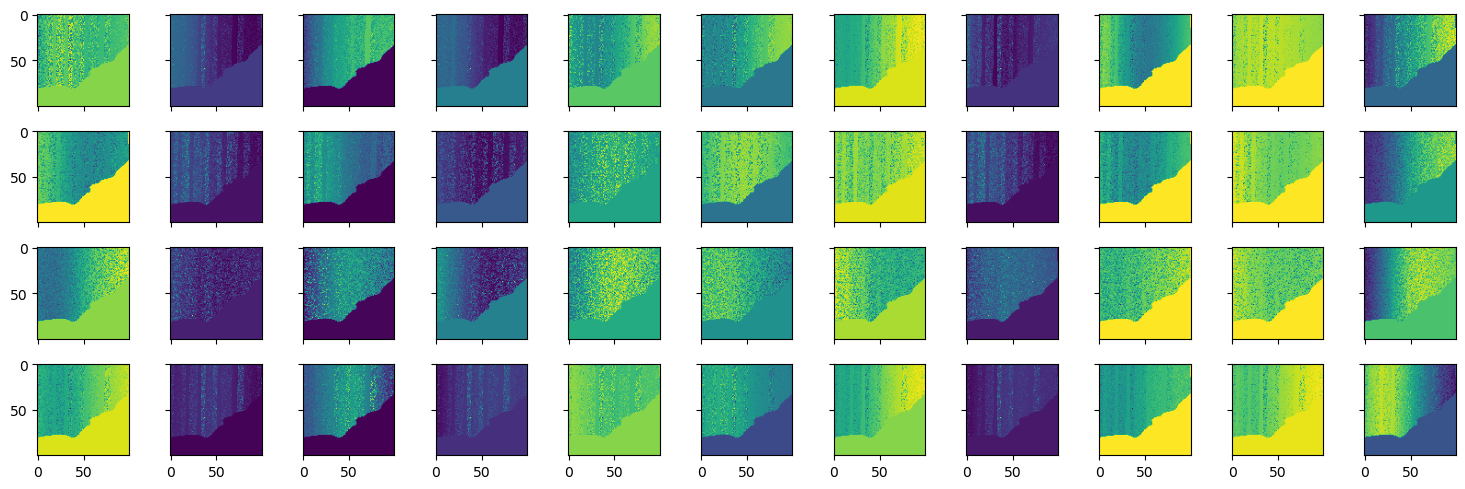

In [24]:
fig, axs = plt.subplots(4, 11, figsize=(15,5), sharex=True, sharey=True)
for i in range(4):
    for j in range(11):
        ax = axs[i,j]
        p = j*3
        ax.imshow(y_pred[i, p, :, :, 0])
plt.tight_layout()
plt.show()

***
# END